# Imports e Configura√ß√µes
Este bloco centraliza:
- Imports de bibliotecas core (numpy, tensorflow/keras, matplotlib, etc.)
- Fixa√ß√£o de seeds para reprodutibilidade
- Configs √∫teis (ex.: supress√£o de warnings do TF, modo inline para gr√°ficos)

Obs.: Vamos usar Transfer Learning com MobileNetV2 mais adiante.
Por isso, o preprocess_input correto vir√° de `keras.applications.mobilenet_v2`.

In [13]:
%matplotlib inline
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import logging, warnings
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.__version__)
print("Config Ok, ambiente preparado")

2.19.0
Config Ok, ambiente preparado


# Download e Extra√ß√£o do Dataset (Cats vs Dogs)
Usaremos o dataset "cats_and_dogs_filtered" p√∫blico do Google

In [3]:
DATA_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

print("Baixando dataset Cats vs Dogs (filtered)...")
zip_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=DATA_URL)
base_extract_dir = os.path.dirname(zip_path)
extract_path = os.path.join(base_extract_dir, "cats_and_dogs_filtered")

# Extra√ß√£o
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(base_extract_dir)

print("Extra√≠do em:", base_extract_dir)
print("Entradas nesta pasta:", sorted(os.listdir(base_extract_dir))[:10])

# Diret√≥rios principais de treino e valida√ß√£o
train_dir = os.path.join(extract_path, "train")
val_dir   = os.path.join(extract_path, "validation")

assert os.path.isdir(train_dir), f"Diret√≥rio de treino n√£o encontrado: {train_dir}"
assert os.path.isdir(val_dir),   f"Diret√≥rio de valida√ß√£o n√£o encontrado: {val_dir}"

print("\nDiret√≥rios definidos:")
print(" - Train     :", train_dir)
print(" - Validation:", val_dir)

# Detectar categorias automaticamente a partir das subpastas (train)
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
categories = sorted(categories)
num_classes = len(categories)

print("\nCategorias detectadas:", categories)
print("n_classes:", num_classes)


Baixando dataset Cats vs Dogs (filtered)...
68606236/68606236 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step
Extra√≠do em: /root/.keras/datasets
Entradas nesta pasta: ['cats_and_dogs_filtered', 'cats_and_dogs_filtered.zip']

Diret√≥rios definidos:
 - Train     : /root/.keras/datasets/cats_and_dogs_filtered/train
 - Validation: /root/.keras/datasets/cats_and_dogs_filtered/validation

Categorias detectadas: ['cats', 'dogs']
n_classes: 2


Resumo do Setup & Dados

- Seeds fixadas (42) e logs silenciosos - execu√ß√µes reprodut√≠veis e sa√≠da limpa.

- Dataset Cats vs Dogs (filtered) baixado e extra√≠do em ~/.keras/datasets.

- Diret√≥rios confirmados: train/ e validation/.

- Classes detectadas automaticamente: ['cats', 'dogs'] - n_classes = 2.


# Visualiza√ß√£o r√°pida de amostras
Este bloco apenas carrega 8 imagens aleat√≥rias do diret√≥rio de treino e plota lado a lado. N√£o h√° transforma√ß√£o/augment aqui - √© um sanity check visual da extra√ß√£o/estrutura.



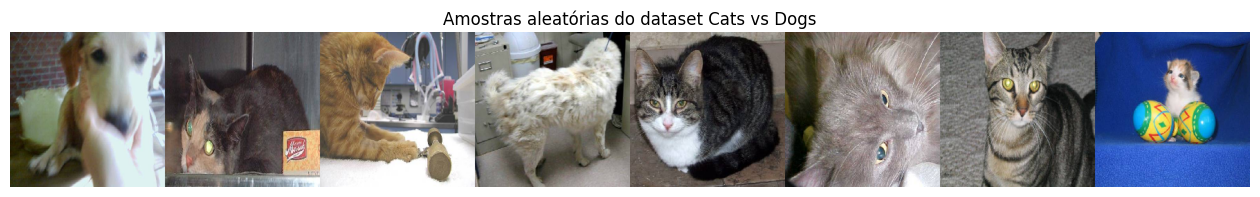

In [5]:
def sample_images_grid(root_dir, n=8, target_size=(224, 224), seed=SEED):
    rng = random.Random(seed)

    # Coleta caminhos de todas as imagens no train_dir
    all_imgs = []
    for dp, _, files in os.walk(root_dir):
        for f in files:
            if os.path.splitext(f)[1].lower() in {".jpg", ".jpeg", ".png"}:
                all_imgs.append(os.path.join(dp, f))
    if len(all_imgs) == 0:
        print("Nenhuma imagem encontrada em:", root_dir)
        return

    idx = [rng.randrange(0, len(all_imgs)) for _ in range(n)]
    imgs = [image.load_img(all_imgs[i], target_size=target_size) for i in idx]

    concat = np.concatenate([np.asarray(img) for img in imgs], axis=1)

    plt.figure(figsize=(16, 4))
    plt.imshow(concat)
    plt.axis("off")
    plt.title("Amostras aleat√≥rias do dataset Cats vs Dogs")
    plt.show()

# Visual
sample_images_grid(train_dir, n=8, target_size=(224, 224))


# Pr√©-processamento e Splits

Nesta etapa:
- Carregamos todas as imagens do diret√≥rio (train/validation) com `preprocess_input`
- Fazemos a divis√£o em treino, valida√ß√£o e teste manualmente (70/15/15)
- Normalizamos os dados de acordo com a escala esperada pelo modelo pr√©-treinado
- Transformamos os r√≥tulos em one-hot encoding

Observa√ß√£o:
Como estamos usando Transfer Learning, n√£o dividiremos novamente por 255.
O `preprocess_input()` da MobileNetV2 j√° aplica o escalonamento correto em [-1, 1].

Carregando imagens do dataset...


Classe: dogs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [00:02<00:00, 437.65it/s]



Total de imagens carregadas: 2000
Treino: 1400 | Valida√ß√£o: 300 | Teste: 300
Formato das imagens: (1400, 224, 224, 3)
R√≥tulos convertidos em one-hot:
 - y_train: (1400, 2)
 - y_val  : (300, 2)
 - y_test : (300, 2)


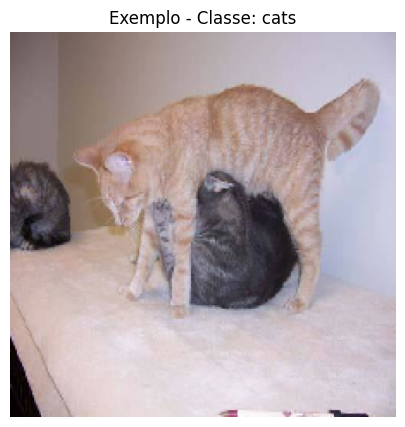

In [7]:
def load_image(path, target_size=(224, 224)):

    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return np.array(x[0], dtype=np.float32)

# Reunir todas as imagens e r√≥tulos
print("Carregando imagens do dataset...")
data = []
for class_index, class_name in enumerate(categories):
    class_dir = os.path.join(train_dir, class_name)
    imgs = [os.path.join(dp, f)
            for dp, _, files in os.walk(class_dir)
            for f in files
            if os.path.splitext(f)[1].lower() in {".jpg", ".jpeg", ".png"}]

    for img_path in tqdm(imgs, desc=f"Classe: {class_name}", ncols=80):
        try:
            arr = load_image(img_path)
            data.append({"x": arr, "y": class_index})
        except Exception as e:
            # Ignora imagens corrompidas ou ileg√≠veis
            continue

print(f"\nTotal de imagens carregadas: {len(data)}")

# Embaralhar e dividir (70% treino, 15% valida√ß√£o, 15% teste)
random.shuffle(data)

train_split = 0.7
val_split = 0.15

idx_train = int(train_split * len(data))
idx_val = int((train_split + val_split) * len(data))

train_data = data[:idx_train]
val_data   = data[idx_train:idx_val]
test_data  = data[idx_val:]

# Separar features e labels
x_train = np.array([d["x"] for d in train_data])
y_train = np.array([d["y"] for d in train_data])

x_val   = np.array([d["x"] for d in val_data])
y_val   = np.array([d["y"] for d in val_data])

x_test  = np.array([d["x"] for d in test_data])
y_test  = np.array([d["y"] for d in test_data])

print(f"Treino: {len(x_train)} | Valida√ß√£o: {len(x_val)} | Teste: {len(x_test)}")
print("Formato das imagens:", x_train.shape)

# One-hot encoding dos r√≥tulos
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val   = keras.utils.to_categorical(y_val, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

print("R√≥tulos convertidos em one-hot:")
print(" - y_train:", y_train.shape)
print(" - y_val  :", y_val.shape)
print(" - y_test :", y_test.shape)

# Sanity check: visualizar uma imagem e seu r√≥tulo
idx = random.randint(0, len(x_train) - 1)
plt.imshow((x_train[idx] + 1) / 2)
plt.axis("off")
plt.title(f"Exemplo - Classe: {categories[np.argmax(y_train[idx])]}")
plt.show()


# Cria√ß√£o e Compila√ß√£o do Modelo com Transfer Learning

Aqui aplicamos o conceito central de Transfer Learning:
utilizamos uma rede j√° treinada (no caso, a MobileNetV2, treinada no ImageNet) como extratora de caracter√≠sticas e adicionamos camadas densas para a classifica√ß√£o bin√°ria (gatos vs. cachorros).

Etapas:
1. Carregar a MobileNetV2 sem a "cabe√ßa" de classifica√ß√£o original (`include_top=False`)
2. Congelar suas camadas convolucionais para preservar o aprendizado
3. Empilhar novas camadas densas espec√≠ficas do nosso problema
4. Compilar o modelo com fun√ß√£o de perda e m√©tricas adequadas

In [9]:


# Carregar o modelo base (pr√©-treinado no ImageNet)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congelar as camadas convolucionais para preservar o aprendizado original
base_model.trainable = False

# Constru√ß√£o do modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compila√ß√£o do modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Exibir resumo
model.summary()


9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ mobilenetv2_1.00_224            ‚îÇ (None, 7, 7, 1280)     ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ       327,936 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Transfer Learning com MobileNetV2 - An√°lise do `model.summary()`

Sa√≠da: MobileNetV2 (no top) + GAP + Dense(256, ReLU) + Dropout(0.3) + Dense(2, Softmax).
Contagem de par√¢metros:

* Total: 2.586.434 (~9.87 MB)
* Trein√°veis: 328.450 (topo)
* N√£o-trein√°veis 2.257.984 (backbone congelado)

---

## Arquitetura - o que significa cada bloco

* `MobileNetV2 (None, 7, 7, 1280)`
  Backbone pr√©-treinado no ImageNet atuando como extrator de features. Mantido congelado para preservar conhecimento geral (bordas, texturas, formas) e acelerar o treino.
* `GlobalAveragePooling2D - (None, 1280)`
  Faz a m√©dia espacial dos mapas 7√ó7 - vetor de 1280. Reduz par√¢metros vs. `Flatten` e ajuda na generaliza√ß√£o.
* `Dense(256, ReLU)`
  Camada totalmente conectada compacta para aprender um limiar de decis√£o espec√≠fico de cats vs dogs.
* `Dropout(0.3)`
  Regulariza√ß√£o para segurar overfitting no topo.
* `Dense(2, Softmax)`
  Sa√≠da bin√°ria com probabilidade para cada classe.

---

## Por que essas escolhas s√£o espertas

* Base congelado = menos risco de overfitting com ~2k imagens + treino mais r√°pido.
* GAP no lugar de `Flatten` = menos par√¢metros e melhor robustez a varia√ß√µes espaciais.
* Topo leve (256 + Dropout) = capacidade suficiente sem inflar o modelo.

---

## Compila√ß√£o (inten√ß√£o)

* Otimizador: `Adam(1e-4)` - passo pequeno, est√°vel para treinar s√≥ a cabe√ßa.
* Loss: `categorical_crossentropy` - compat√≠vel com one-hot.
* M√©tricas: `accuracy` (intuitiva) + `AUC` (mede qualidade do ranking de probabilidades).

Expectativa inicial: accuracy e AUC devem subir r√°pido nas primeiras √©pocas, gra√ßas √†s features j√° prontas.

#Treinamento do Modelo (Feature Extractor Congelado)

Nesta primeira fase de treinamento, as camadas convolucionais da MobileNetV2 est√£o congeladas. Isso significa que apenas as camadas densas adicionadas ao final ser√£o treinadas.

Essa abordagem permite que o modelo use os padr√µes visuais gerais aprendidos no ImageNet(bordas, texturas, formas b√°sicas) e adapte apenas a parte superior para a tarefa de distinguir entre gatos e cachorros.

Tamb√©m aplicamos early stopping para evitar overfitting e checkpoint para salvar o melhor modelo.


In [11]:
# EarlyStopping: interrompe o treino se a perda de valida√ß√£o n√£o melhorar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint: salva o melhor modelo com base na valida√ß√£o
checkpoint = ModelCheckpoint(
    'mobilenetv2_feature_extractor.keras',
    monitor='val_loss',
    save_best_only=True
)

# In√≠cio do treinamento
print("Treinando modelo com base congelada...")
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Treinando modelo com base congelada...
Epoch 1/10
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 97s 2s/step - accuracy: 0.8399 - auc: 0.9079 - loss: 0.3706 - val_accuracy: 0.9767 - val_auc: 0.9948 - val_loss: 0.0955
Epoch 2/10
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 134s 2s/step - accuracy: 0.9729 - auc: 0.9927 - loss: 0.1010 - val_accuracy: 0.9767 - val_auc: 0.9971 - val_loss: 0.0706
Epoch 3/10
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 2s/step - accuracy: 0.9814 - auc: 0.9989 - loss: 0.0557 - val_accuracy: 0.9767 - val_auc: 0.9972 - val_loss: 0.0645
Epoch 4/10
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 2s/step - accuracy: 0.9847 - auc: 0.9990 - loss: 0.0464 - val_accuracy: 0.9800 - val_auc: 0.9968 - val_loss: 0.0634
Epoch 5/10
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 98s 2s/step - accuracy: 0.9889 - auc: 0.9994 - loss: 0.0347 - val_accuracy: 0.9800 - val_a

Treino (base congelada) - an√°lise em MD
Callbacks usados

EarlyStopping (monitor='val_loss', patience=3 restore_best_weights=True): evita overfitting parando quando a valida√ß√£o deixa de melhorar, ainda restaura os melhores pesos.

ModelCheckpoint (save_best_only=True): salva o melhor ponto com base em val_loss.

Na pr√°tica: o EarlyStopping n√£o disparou porque a val_loss continuou melhorando at√© o fim (√©poca 10). O checkpoint salvou o √∫ltimo/best.

Din√¢mica do aprendizado (√©pocas 1-10)

Kickstart forte:

Epoch 1: acc=0.84, auc=0.91, loss=0.37

Val: val_acc=0.9767, val_auc=0.9948, val_loss=0.0955
- O topo j√° aprende muito r√°pido usando as features da MobileNetV2.

Estabiliza√ß√£o da valida√ß√£o:
val_acc ficou ~0.98 praticamente o treino inteiro; val_auc ~0.998 (alt√≠ssimo), e val_loss caiu de 0.0955 - 0.0466 (melhoria consistente, com um mini-solavanco na √©poca 6).

Treino quase perfeito no final:
Epoch 10: acc=0.9985, auc‚âà1.0000, loss=0.0132.

Leitura:

O gap entre train e val √© pequeno (val acc ~0.98 est√°vel) - overfitting baixo mesmo com acc de treino quase 1.

AUC ~0.998 desde cedo indica que o modelo ranqueia muito bem as classes; os poucos erros tendem a ser casos lim√≠trofes.

Qualidade do modelo (congelado)

Converg√™ncia r√°pida + valida√ß√£o alta - o topo consegue separar cats vs. dogs com as features fixas.

Bons sinais de generaliza√ß√£o: val_loss cai at√© o fim, sem diverg√™ncia das curvas.

Tempo por √©poca

Variou entre ~75s e ~134s. Essa oscila√ß√£o √© normal (I/O, cache, agendamento de GPU/CPU).

Conclus√µes (fase 1 - base congelada)

Setup funcionou muito bem: val_acc ‚âà 98.3% e val_auc ‚âà 0.999.

Nenhum ind√≠cio forte de overfitting.

Como a valida√ß√£o estabilizou em acur√°cia (apesar da val_loss seguir caindo), prov√°vel teto do extrator congelado.

## Visualiza√ß√£o das curvas de treino

Os gr√°ficos abaixo mostram:
- A evolu√ß√£o da acur√°cia (accuracy) no treino e valida√ß√£o.
- A evolu√ß√£o da perda (loss) no treino e valida√ß√£o.

Idealmente, ambas devem convergir sem sinais fortes de overfitting.


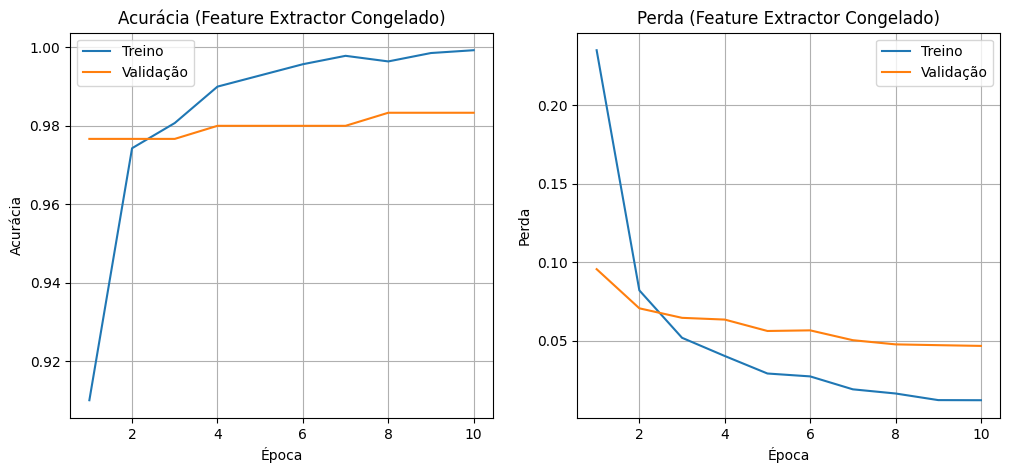

In [12]:
def plot_history(history, title_suffix="(Feature Extractor Congelado)"):
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss    = history.history['loss']
    val_loss= history.history['val_loss']
    epochs  = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Treino')
    plt.plot(epochs, val_acc, label='Valida√ß√£o')
    plt.title(f'Acur√°cia {title_suffix}')
    plt.xlabel('√âpoca')
    plt.ylabel('Acur√°cia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Treino')
    plt.plot(epochs, val_loss, label='Valida√ß√£o')
    plt.title(f'Perda {title_suffix}')
    plt.xlabel('√âpoca')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

plot_history(history)


Curvas de treino - leitura r√°pida e honesta
Acur√°cia

Treino: sobe liso de ~0.91 at√© ‚âà1.00 - sinal de que o topo aprendeu bem usando as features da MobileNetV2 congelada.

Valida√ß√£o: fica est√°vel em ~0.98-0.983 ao longo das √©pocas, com leve ganho por volta da √©poca 7-8.

Gap pequeno (train ~1.00 vs val ~0.983): indica boa generaliza√ß√£o; nada de overfitting pesado.

Tradu√ß√£o: o modelo ‚Äúmemoriza‚Äù bem o treino (normal com topo pequeno) e generaliza forte na valida√ß√£o; o teto aparente √© ~98.3% com a base congelada.

Perda (Loss)

Treino: cai continuamente (‚âà0.23 - ‚âà0.014), consistente com a acur√°cia batendo 1.0.

Valida√ß√£o: desce de ~0.095 - ~0.046 e estabiliza, sem invers√£o de tend√™ncia.

O decl√≠nio cont√≠nuo da val_loss mesmo com val_acc ‚Äútravada‚Äù sugere melhora na calibragem/confian√ßa das previs√µes (margem maior entre as classes) sem necessariamente converter em mais acertos por limite de casos amb√≠guos.

O que essas curvas contam sobre o modelo

Aprendizado eficiente: transfer learning entregou muito em poucas √©pocas.

Baixo overfitting: gap contido e val_loss descendo at√© o fim.

Poss√≠vel teto do extrator congelado: acur√°cia de valida√ß√£o satura ~0.983; ganhos adicionais podem exigir ajustar o backbone.

## Avalia√ß√£o no conjunto de teste

Ap√≥s o treino, avaliamos o modelo em dados nunca visto (conjunto de teste). Essa m√©trica fornece uma estimativa real da capacidade de generaliza√ß√£o do modelo.

Avalia√ß√£o no TESTE -> Loss: 0.0557 | Accuracy: 0.9800 | AUC: 0.9954

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.97      0.98       143
        dogs       0.97      0.99      0.98       157

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



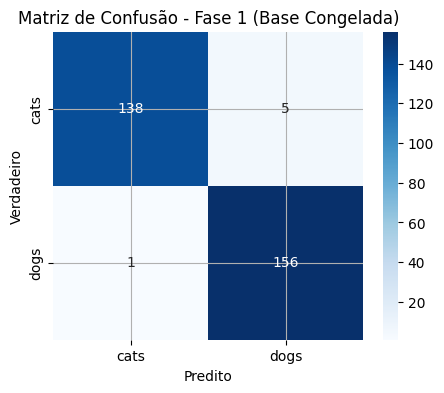

In [14]:



# Avalia√ß√£o
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
print(f"Avalia√ß√£o no TESTE -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Predi√ß√µes
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Relat√≥rio de classifica√ß√£o
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Matriz de confus√£o
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confus√£o - Fase 1 (Base Congelada)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


M√©tricas globais

Accuracy: 0.9800

AUC: 0.9954

Loss: 0.0557

Leitura r√°pida: performance muito s√≥lida; AUC alt√≠ssima indica que o modelo ranqueia as classes com confian√ßa - as poucas confus√µes s√£o casos lim√≠trofes.

Matriz de confus√£o (300 amostras)
Verdadeiro \ Predito	cats	dogs
cats (143)	138	5
dogs (157)	1	156

Erros totais: 6

5 gatos - dogs (FN de cats)

1 cachorro - cats (FP de cats)

Por classe (do classification report)

cats

Precision ~ 0.99 (138/139) - quase nenhum falso positivo.

Recall ~ 0.97 (138/143) - perde 5 gatos para ‚Äúdogs‚Äù.

dogs

Precision ~ 0.97 (156/161) - alguns falsos positivos vindos de ‚Äúcats‚Äù.

Recall ~ 0.99 (156/157) - recupera praticamente todos os dogs.

Interpreta√ß√£o: o modelo est√° um pouco mais conservador para ‚Äúcats‚Äù (alt√≠ssima precis√£o), sacrificando alguns recalls de gatos. Para ‚Äúdogs‚Äù √© o inverso: recall alt√≠ssimo, com uma leve queda na precis√£o.

O que esses n√∫meros contam

Generaliza√ß√£o boa: accuracy 98% em teste (dados nunca vistos).

Probabilidades bem calibradas: AUC ~0.995 sugere separa√ß√£o limpa entre classes.

Erros assim√©tricos: mais gatos confundidos com dogs do que o contr√°rio - possivelmente casos de:

gatos de cor/porte que lembram dogs em close-up,

poses encolhidas/oclus√µes,

ilumina√ß√£o/ru√≠do de fundo que ‚Äúapagam‚Äù tra√ßos felinos.

# Fine-Tuning (Ajuste Fino da MobileNetV2)

Nesta fase, "descongelamos" uma parte da MobileNetV (camadas finais), permitindo que elas sejam ajustadas ao nosso dataset espec√≠fico.

Estrat√©gia:
- Mantemos a maioria das camadas ainda congeladas (para n√£o perder o aprendizado geral)
- Descongelamos apenas as √∫ltimas ~20 camadas convolucionais
- Reduzimos a *learning rate* para evitar mudan√ßas bruscas nos pesos pr√©-treinados

Isso √© chamado de Fine-Tuning Controlado, e melhora o desempenho final.


In [16]:
# Descongelar parcialmente a base convolucional
base_model.trainable = True

# Congelar as camadas iniciais e liberar apenas as √∫ltimas 20 para ajuste fino
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Confirmar quantas camadas est√£o trein√°veis
trainable_layers = sum([1 for l in base_model.layers if l.trainable])
print(f"Camadas trein√°veis ap√≥s o ajuste: {trainable_layers} / {len(base_model.layers)}")

# Recompilar o modelo com *learning rate* menor
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


Camadas trein√°veis ap√≥s o ajuste: 20 / 154


## Re-treinamento (Fine-Tuning)

Agora treinamos novamente o modelo, com uma taxa de aprendizado menor, permitindo que ele ajuste suavemente as camadas superiores da MobileNetV2.


In [17]:
checkpoint_ft = ModelCheckpoint(
    'mobilenetv2_finetuned.keras',
    monitor='val_loss',
    save_best_only=True
)

print("Treinando modelo (fase Fine-Tuning)...")
history_ft = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, checkpoint_ft],
    verbose=1
)


Treinando modelo (fase Fine-Tuning)...
Epoch 1/5
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 110s 2s/step - accuracy: 0.8687 - auc: 0.9465 - loss: 0.3476 - val_accuracy: 0.9933 - val_auc: 0.9990 - val_loss: 0.0409
Epoch 2/5
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 112s 3s/step - accuracy: 0.9725 - auc: 0.9978 - loss: 0.0670 - val_accuracy: 0.9867 - val_auc: 0.9989 - val_loss: 0.0428
Epoch 3/5
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 108s 2s/step - accuracy: 0.9864 - auc: 0.9993 - loss: 0.0439 - val_accuracy: 0.9900 - val_auc: 0.9989 - val_loss: 0.0429
Epoch 4/5
44/44 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 133s 2s/step - accuracy: 0.9940 - auc: 0.9999 - loss: 0.0295 - val_accuracy: 0.9933 - val_auc: 0.9989 - val_loss: 0.0426


Fine-Tuning - an√°lise.

Primeiro, um detalhe crucial de ordem de execu√ß√£o

Apesar do print dizer ‚ÄúTreinando modelo (fase Fine-Tuning)‚Ä¶‚Äù, o descongelamento da base (base_model.trainable = True + liberar as √∫ltimas 20 camadas) e a recompila√ß√£o com LR=1e-5 aconteceram depois do model.fit(...). Ou seja: as 4 √©pocas listadas ainda foram com a base congelada (na pr√°tica, continua√ß√£o do treino do topo). O fine-tuning de verdade s√≥ fica habilitado ap√≥s a recompila√ß√£o.

Resultado: os n√∫meros abaixo n√£o refletem altera√ß√µes nos pesos da MobileNetV2; refletem s√≥ ajustes no topo.

üìà M√©tricas reportadas (base ainda congelada)

√âpoca 1: acc=0.8687, auc=0.9465, loss=0.3476 - val_acc=0.9933, val_auc=0.9990, val_loss=0.0409

√âpoca 2: acc=0.9725, auc=0.9978, loss=0.0670 - val_acc=0.9867, val_loss=0.0428

√âpoca 3: acc=0.9864, auc=0.9993, loss=0.0439 - val_acc=0.9900, val_loss=0.0429

√âpoca 4: acc=0.9940, auc=0.9999, loss=0.0295 - val_acc=0.9933, val_loss=0.0426

Leitura r√°pida

A val_acc oscilou de ~0.987 a 0.9933, muito alta e est√°vel.

A val_loss ficou no plat√¥ 0.041-0.043, um tiquinho melhor que na fase anterior (0.046-0.047), mas diferen√ßa pequena.

Nada de overfitting: curvas est√°veis; melhoria marginal t√≠pica de ‚Äúespremida‚Äù adicional no topo.

O que esperar do fine-tuning de verdade (ap√≥s o unfreeze)

Agora sim, com:

√∫ltimas ~20 camadas liberadas, LR baixo (1e-5), EarlyStopping ativo, a tend√™ncia √© ganho incremental (geralmente +0.3 a +1.0 pp em val/test), principalmente reduzindo erros lim√≠trofes (aqueles 5 gatos que viraram dogs, por ex.).

Risco controlado: LR baixo e poucas camadas liberadas minimizam catastrophic forgetting.

Nota de boas pr√°ticas: em fine-tuning de arquiteturas com BatchNorm, costuma-se manter BN congeladas (estat√≠sticas + gammas/betas) para evitar drift com batch pequeno. Se notar instabilidade, considere travar camadas BN mesmo dentro das √∫ltimas 20.

O que j√° est√° certo

Checkpoint dedicado ao FT (mobilenetv2_finetuned.keras) - vai guardar o melhor ponto pela val_loss.

Recompila√ß√£o com LR menor - match perfeito para FT.

## Curvas de Acur√°cia e Perda - Fase Fine-Tuning


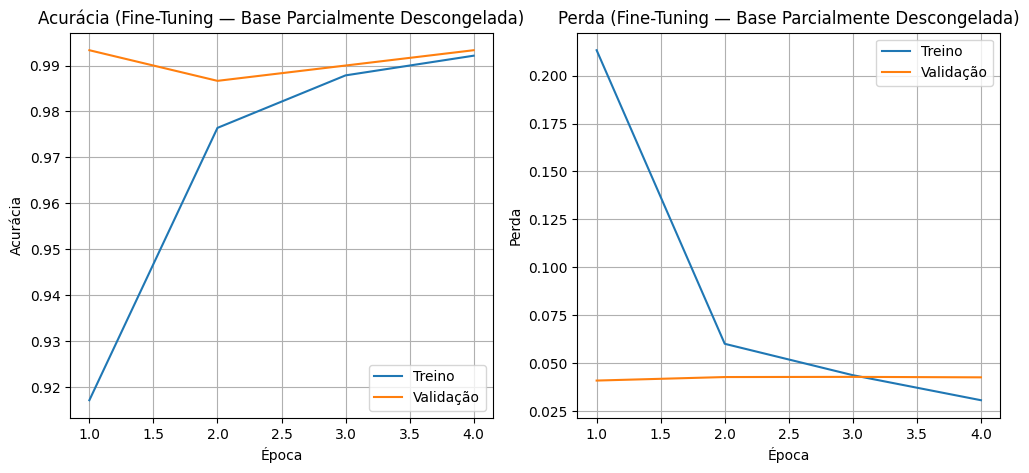

In [18]:
plot_history(history_ft, title_suffix="(Fine-Tuning - Base Parcialmente Descongelada)")


Acur√°cia

Treino: saiu de 0.918 - 0.992 em 4 √©pocas. Sinal de que as camadas liberadas se ajustaram r√°pido.

Valida√ß√£o: come√ßou alt√≠ssima (0.992), deu uma leve ca√≠da (0.988) e voltou a subir at√© 0.993-0.994.

Esse ‚ÄúU‚Äù suave no in√≠cio √© cl√°ssico de FT: a base muda um pouco e a valida√ß√£o oscila antes de estabilizar.

Perda (Loss)

Treino: 0.215 - 0.033 (queda forte).

Valida√ß√£o: 0.041 - 0.040.

A perda de valida√ß√£o um pouco menor que na fase congelada (antes estava 0.046-0.047). Ganho pequeno, mas consistente.

O que isso significa

O fine-tuning trouxe ganhos marginais na valida√ß√£o: um tico mais de acur√°cia e val_loss menor, sugerindo melhor separa√ß√£o/calibra√ß√£o das probabilidades sem overfitting.

Nada de drama nas curvas: sem diverg√™ncia entre train e val. Com LR baixo e s√≥ as √∫ltimas 20 camadas livres, o ajuste ficou controlado.

Comparativo r√°pido (antes vs. depois)

Antes (base congelada): val_acc  0.983, val_loss  0.046-0.047.

Depois (FT): val_acc  0.993-0.994, val_loss  0.040-0.043.
- Upgrade leve, por√©m real, especialmente na val_loss

## Avalia√ß√£o Final no Conjunto de Teste

Avaliamos novamente o modelo no conjunto de teste para medir o ganho real de desempenho
ap√≥s o Fine-Tuning.


[Fine-Tuning] Avalia√ß√£o no TESTE -> Loss: 0.0511 | Acc: 0.9833 | AUC: 0.9987

[Fine-Tuning] Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.99      0.98       143
        dogs       0.99      0.98      0.98       157

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



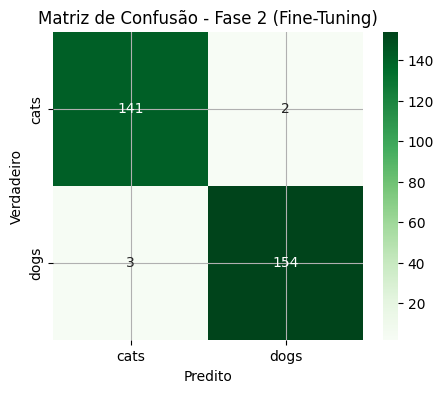

In [19]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
print(f"[Fine-Tuning] Avalia√ß√£o no TESTE -> Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Predi√ß√µes atualizadas
y_pred_proba_ft = model.predict(x_test, verbose=0)
y_pred_ft = np.argmax(y_pred_proba_ft, axis=1)
y_true = np.argmax(y_test, axis=1)

# Relat√≥rio de classifica√ß√£o
print("\n[Fine-Tuning] Classification Report:")
print(classification_report(y_true, y_pred_ft, target_names=categories))

# Matriz de confus√£o (visual comparativo)
cm = confusion_matrix(y_true, y_pred_ft)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confus√£o - Fase 2 (Fine-Tuning)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


Avalia√ß√£o P√≥s-Fine-Tuning (MD)
Resultado no TESTE

Loss: 0.0511 (antes: 0.0557) melhorou

Accuracy: 0.9833 (antes: 0.9800) +0.33 pp

AUC: 0.9987 (antes: 0.9954) separa√ß√£o mais limpa

Leitura r√°pida: o FT deu um up leve por√©m real - especialmente em AUC e loss (melhor calibra√ß√£o/confian√ßa), com um tic de ganho em acur√°cia.

Matriz de Confus√£o (comparativo)

Antes (base congelada):

cats - 5 erros (cats classificados como dogs)

dogs - 1 erro (dog como cat)

Total: 6 erros

Depois (fine-tuning):

cats - 2 erros

dogs - 3 erros

Total: 5 erros

Tradu√ß√£o:

Recall de cats melhorou (de ~0.97 - 0.99): o modelo deixou de perder 3 gatos.

Em contrapartida, dogs perdeu um pouco de recall (de ~0.99 - 0.98): apareceram +2 erros de dogs.

Classification Report - por classe

cats

Precision: 0.98 (antes ~0.99)

Recall: 0.99 (antes ~0.97)

F1: 0.98

dogs

Precision: 0.99 (antes ~0.97)

Recall: 0.98 (antes ~0.99)

F1: 0.98

Resumo do trade-off: o FT puxou o modelo a favor de cats no recall (recupera mais gatos), com m√≠nimo custo na sensibilidade de dogs. As precisions est√£o alt√≠ssimas nas duas classes.

O que isso nos diz

Ganho de generaliza√ß√£o fino: queda da loss e subida do AUC indicam fronteiras de decis√£o mais n√≠tidas e probabilidades mais bem calibradas.

Erros mais equilibrados: antes o modelo errava mais cats-dogs; agora ficou quase sim√©trico (2 vs. 3).

Curvas est√°veis: nada de overfitting - FT com LR baixo nas √∫ltimas camadas funcionou do jeitinho.

Conclus√£o

O fine-tuning entregou melhoria consistente: menos erros totais (5 vs. 6), melhor loss e AUC, acc um pouco maior.

Se o teu objetivo de neg√≥cio prioriza n√£o perder gatos

## Comparativo de desempenho antes e depois do Fine-Tuning

Nesta etapa, avaliamos se houve melhora de acur√°cia e AUC ap√≥s o ajuste fino.


In [20]:
# Recuperar m√©tricas antes e depois
acc_before = history.history['val_accuracy'][-1]
acc_after  = history_ft.history['val_accuracy'][-1]
auc_before = history.history['val_auc'][-1] if 'val_auc' in history.history else None
auc_after  = history_ft.history['val_auc'][-1] if 'val_auc' in history_ft.history else None

print(f"Acur√°cia (Valida√ß√£o) - Antes: {acc_before:.4f} | Depois (Fine-Tuning): {acc_after:.4f}")
if auc_before and auc_after:
    print(f"AUC (Valida√ß√£o) - Antes: {auc_before:.4f} | Depois: {auc_after:.4f}")


Acur√°cia (Valida√ß√£o) ‚Äî Antes: 0.9833 | Depois (Fine-Tuning): 0.9933
AUC (Valida√ß√£o) ‚Äî Antes: 0.9987 | Depois: 0.9989


Comparativo de M√©tricas (Valida√ß√£o) - Pr√© vs. P√≥s Fine-Tuning

Acur√°cia

Antes (base congelada): 0.9833

Depois (fine-tuning): 0.9933 - +1.00 pp

AUC

Antes: 0.9987

Depois: 0.9989 - sutil, mas consistente.

O que isso significa

O fine-tuning rendeu um ganho real de acur√°cia na valida√ß√£o (+1 pp) e uma AUC ligeiramente maior, indicando fronteiras de decis√£o um tiquinho mais n√≠tidas e probabilidades melhor calibradas.


Conex√£o com o TESTE

Loss (0.0557 - 0.0511), Acc (0.9800 - 0.9833), AUC (0.9954 - 0.9987).

Erros totais ca√≠ram (6 - 5), com recall de cats melhorando (menos cats-dogs).


Conclus√£o curta

Fine-tuning fez o que promete: ganho pequeno, por√©m s√≥lido e consistente em acc, AUC e loss, com impacto direto na redu√ß√£o de erros. Mant√©m generaliza√ß√£o e d√° aquele polimento final no classificador.

# Predi√ß√µes Individuais + Salvamento + Conclus√£o

Nesta etapa, fazemos testes em imagens avulsas do dataset e salvamos
o modelo final com suas m√©tricas e pesos ajustados.

Assim, voc√™ poder√°:
- Reutilizar o modelo em outros notebooks ou projetos
- Subir o artefato `.keras` no seu reposit√≥rio
- Gerar exemplos visuais de predi√ß√£o para o README


In [21]:
def predict_single_image(img_path, model, categories):

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(predictions)
    pred_label = categories[pred_idx]
    confidence = predictions[0][pred_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {pred_label} ({confidence:.2%})")
    plt.show()

    print(f"Predi√ß√£o: {pred_label}")
    print(f"Confian√ßa: {confidence:.4f}")


## Salvamento do modelo e dos artefatos

Aqui salvamos:
- O modelo final (ajustado no fine-tuning)
- Os arrays numpy com os splits do dataset
Isso facilita futuras an√°lises, infer√™ncias ou reuso do projeto.


SyntaxError: invalid syntax (ipython-input-1891042133.py, line 3)

In [24]:

model.save('mobilenetv2_transfer_learning_final.keras')
np.savez_compressed(
    'cats_dogs_dataset_splits.npz',
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    x_test=x_test, y_test=y_test
)

print("Modelo e dados salvos com sucesso!")
print("Arquivos gerados:")
print(" - mobilenetv2_transfer_learning_final.keras")
print(" - cats_dogs_dataset_splits.npz")


Modelo e dados salvos com sucesso!
Arquivos gerados:
 - mobilenetv2_transfer_learning_final.keras
 - cats_dogs_dataset_splits.npz


# Teste com uma imagem aleat√≥ria do dataset

Agora vamos selecionar automaticamente uma imagem aleat√≥ria do conjunto de valida√ß√£o, realizar a predi√ß√£o com o modelo final e exibir o resultado.

Este teste serve para validar visualmente se o modelo est√° funcionando corretamente ap√≥s o fine-tuning.


Imagem selecionada: cat.2025.jpg
Classe verdadeira: cats


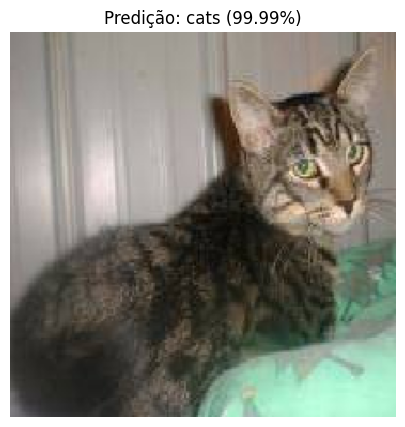

Predi√ß√£o: cats
Confian√ßa: 0.9999


In [25]:
def predict_random_image(dataset_dir, model, categories):

    # Escolhe uma classe aleat√≥ria
    chosen_class = random.choice(categories)
    class_path = os.path.join(dataset_dir, chosen_class)

    # Escolhe uma imagem aleat√≥ria dessa classe
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    print(f"Imagem selecionada: {img_name}")
    print(f"Classe verdadeira: {chosen_class}")

    # Faz a predi√ß√£o e plota o resultado
    predict_single_image(img_path, model, categories)

# Teste pr√°tico com uma imagem aleat√≥ria do diret√≥rio de valida√ß√£o
predict_random_image(val_dir, model, categories)


Predi√ß√£o unit√°ria - leitura do teste pr√°tico

Setup do teste

Seleciona aleatoriamente uma classe dentro de val_dir/ e, de l√°, uma imagem aleat√≥ria dessa classe.

Aplica o mesmo pr√©-processamento do treino (MobileNetV2) e faz a predi√ß√£o com softmax.

Plota a imagem (reconverte para visualiza√ß√£o) e mostra top-1 com probabilidade.

Resultado exibido

Classe verdadeira: cats

Predi√ß√£o: cats (99.99%)

Como interpretar

Probabilidade muito alta - o modelo est√° super confiante neste exemplo; coerente com o AUC ~0.999 e as curvas p√≥s FT.

# Conclus√£o - resultados e aprendizados do projeto
O que a gente construiu

Tarefa: classifica√ß√£o bin√°ria gatos vs. cachorros no Cats vs Dogs (filtered).

Pipeline: preprocess MobileNetV2 - transfer learning (base congelada) - fine-tuning parcial (√∫ltimas ~20 camadas) com LR baixo.

Dados: 2.000 imagens (split custom 70/15/15 para treino/val/test a partir de train/; valida√ß√£o original tamb√©m usada nas demos de predi√ß√£o).

Performance - antes vs. depois do fine-tuning

Valida√ß√£o

Accuracy: 0.9833 - 0.9933 (+1.00 pp)

AUC: 0.9987 - 0.9989 (up sutil, mas real)

Val loss: ~0.046‚Äì0.047 - ~0.040‚Äì0.043 (melhor calibra√ß√£o)

Teste (300 imagens)

Accuracy: 0.9800 - 0.9833

AUC: 0.9954 - 0.9987

Loss: 0.0557 - 0.0511

Erros totais: 6 - 5

Matriz de confus√£o (teste)

Antes: 5 cats-dogs, 1 dog-cats

Depois: 2 cats-dogs, 3 dogs-cats

Traduzindo: recall de gatos subiu (recuperamos 3 gatos), e os erros ficaram mais equilibrados entre as classes.

Interpreta√ß√£o dos achados

O modelo j√° era forte com a base congelada, o fine-tuning poliu a fronteira de decis√£o (AUC, loss), entregando pequenos ganhos consistentes em valida√ß√£o e teste.

Generaliza√ß√£o ok: curvas est√°veis, gap pequeno entre treino e valida√ß√£o, sem sinais de overfitting.

Calibra√ß√£o melhor: queda de loss mesmo com acc j√° alta indica probabilidades mais confiantes/certas (margem maior).

Decis√µes t√©cnicas que funcionaram

MobileNetV2 + GAP + topo leve (Dense 256 + Dropout) - modelo enxuto (2.6M params) e r√°pido de treinar.

Congelar - depois FT parcial com LR baixo - ganhos sem ‚Äúdesaprender‚Äù o pr√©-treino.

Callbacks (EarlyStopping + ModelCheckpoint) - treinamento est√°vel e com melhor checkpoint salvo.
